In [1]:
%load_ext autoreload
%autoreload 2
#Basic package
import math
import random
import time
import numpy as np
import pandas as pd
import xlwt
#ML
from scipy.spatial.distance import cdist
from scipy.cluster.vq import vq
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans  
from sklearn.datasets import make_blobs
from sklearn import cluster, datasets
#Plot
from matplotlib.pyplot import *
from pylab import *
import matplotlib.pyplot as plt
#functions for the framework
from util import *

import warnings
warnings.filterwarnings('ignore')

# Data visulazation

* a1.csv: 20 clusters
* a2.csv: 35 clusters
* a3.csv: 50 clusters
* s1.csv: 9% overlap
* s2.csv: 22% overlap
* s3.csv: 41% overlap
* s4.csv: 44% overlap
* unbalance.csv
* dim032.csv  
* dim064.csv
* dim128.csv
* dim256.csv
* dim512.csv
* dim 1024.csv
* birch1.csv
* birch2.csv
* birch3.csv

In [2]:
##################
data = 'a1.csv'
##################

##  Visual Raw Data and Ground Truth

(3000, 2)
(20, 2) <class 'numpy.ndarray'>


Text(0.5, 1.0, 'a1')

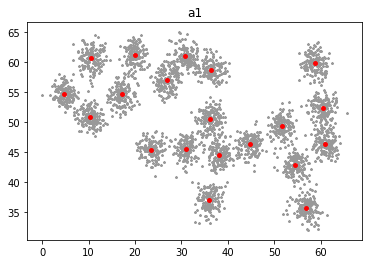

In [3]:
dataMat = pd.read_csv('./Raw_data/all/'+data, header=None, dtype=np.float64).values/1000
print(dataMat.shape)
plt.scatter(dataMat[:, 0],dataMat[:, 1], s=5, c='0.6', marker='*')

gt = pd.read_csv('./Groundtruth/all/'+data, dtype=np.float64).values/1000
print(gt.shape,type(gt))
#plot(gt[:, 0],gt[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plt.scatter(gt[:, 0],gt[:, 1], s=15, c='r', marker='o')
plt.title(data.strip(".csv"))

# Experiment Setting

- Proposed Fission Fusion Framework
**One fit many detection method**
 - standard deviation 
 - radius
**Many fit one detection method**
 - pairwise distance
 - Voronoi (seems to work better for clusters with higher seperation)

In [9]:
def expriment(data, trials, data_gt=None, ofm_method='std', init_method='random', maxIter=30, radius_method='min', start_epsilon=1):
    if data_gt==None:
        data_gt = data
    ####raw_data####
    X = pd.read_csv('./Raw_data/all/'+data, header=None, dtype=np.float64).values 
    ####ground truth####
    gt = pd.read_csv('./Groundtruth/all/'+data_gt, dtype=np.float64).values
    ##################
    ####setting####
    ##################
    k = len(gt)
    SSE_list = []
    CI_list = []
    Iters = []
    Success_rate = 0 
    ##################
    ####Groud truth SSE
    ##################
    gt_model = KMeans(n_clusters=k,init=gt, random_state = 0, n_init=1, algorithm='full').fit(X)
    gt_sse = gt_model.inertia_
    ##################          
    #Main Loop
    ################## 
    start_time=time.time()
    next_seed = 0
    for i in range(trials):
        if ofm_method == 'std++':
            store_C,SSE,next_seed, _,_ = FissionFusion(X, k, seed=next_seed, 
                                                   ofm_method=ofm_method, init_method='k-means++', 
                                                   radius_method=radius_method,
                                                   maxIter=2*k,
                                                   start_epsilon=start_epsilon)            
        else:
            store_C,SSE,next_seed, _,_ = FissionFusion(X, k, seed=next_seed, 
                                                   ofm_method=ofm_method, init_method=init_method, 
                                                   radius_method=radius_method,
                                                   maxIter=2*k,
                                                   start_epsilon=start_epsilon)
        ##################          
        #Centroid Index
        ################## 
        CI = Centroid_Index(gt,store_C[-1])
        CI_list.append(CI)
        SSE_list.append(SSE[-1])
        if CI == 0:
            Success_rate+=1 
        Iters.append(len(store_C))
    Success_rate = Success_rate/trials * 100
    AMR = np.mean(CI_list)/k
    SSE_ratio = np.array(SSE_list)/gt_sse
    SSE_ratio_mean = np.mean(SSE_ratio)
    SSE_ratio_std = np.std(SSE_ratio)
    Iters_mean = np.mean(Iters)
    elapse_time = time.time()-start_time
    
    return (Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std, Iters_mean, elapse_time)

## Experiment on Datasets

In [15]:
experiment_record = {}
datasets = ['a1.csv', 'a2.csv', 'a3.csv',
           's1.csv', 's2.csv', 's3.csv','s4.csv',
           'unbalance.csv','dim032.csv','birch1.csv']
           #['a1_vary.csv', 'a2_vary.csv', 'a3_vary.csv', 'a3_vary2.csv' ]
           #['dim032.csv','dim064.csv','dim128.csv','dim256.csv','dim512.csv','dim1024.csv']
           #['a1.csv', 'a2.csv', 'a3.csv']
           #['s1.csv', 's2.csv', 's3.csv','s4.csv']
           #['dim032.csv','dim064.csv','dim128.csv','dim256.csv','dim512.csv','dim1024.csv']
           #['unbalance.csv','birch1.csv' ]
            
#datasets_gt = ['a1.csv', 'a2.csv']
algorithm = ['radius','std','std++']

for index, data in enumerate(datasets):
    print (data)
    for sub_index, ofm_method in enumerate(algorithm):
        Success_rate, AMR, SSE_ratio_mean, SSE_ratio_std, Iters_mean, elapse_time = expriment(data, trials=100, 
        data_gt=None, ofm_method=ofm_method, init_method='random', radius_method='min', start_epsilon=1)
        experiment_record[index*3+sub_index]= {'dataset': data,
                                               'method': ofm_method,
                                               'success_rate': Success_rate,
                                               'AMR': AMR,
                                               'SSE_ratio_mean': SSE_ratio_mean,
                                               'SSE_ratio_std': SSE_ratio_std,
                                               'Iters': Iters_mean,
                                               'Time': elapse_time}

    
pd.DataFrame.from_dict(experiment_record, orient='index')

a1.csv
a2.csv
a3.csv
s1.csv
s2.csv
s3.csv
s4.csv
unbalance.csv
dim032.csv
birch1.csv


,dataset,method,success_rate,AMR,SSE_ratio_mean,SSE_ratio_std,Iters,Time
0,a1.csv,radius,100.0,0.000000,0.999673,5.987576e-05,26.72,51.719589
1,a1.csv,std,100.0,0.000000,0.999634,3.215266e-06,41.00,73.467559
2,a1.csv,std++,100.0,0.000000,0.999632,3.295466e-06,41.00,76.388715
3,a2.csv,radius,100.0,0.000000,0.999953,3.903802e-05,5.87,23.859478
4,a2.csv,std,100.0,0.000000,0.999911,5.227996e-06,71.00,229.896515
5,a2.csv,std++,100.0,0.000000,0.999914,7.975084e-06,71.00,232.080676
6,a3.csv,radius,100.0,0.000000,1.000017,6.171090e-05,8.09,51.354996
7,a3.csv,std,100.0,0.000000,0.999990,2.593558e-05,8.36,48.003167
8,a3.csv,std++,100.0,0.000000,0.999996,3.259953e-05,5.22,34.380477
9,s1.csv,radius,100.0,0.000000,0.999978,3.278266e-06,7.59,21.197107


In [16]:
#save dataframe
pd.DataFrame.from_dict(experiment_record, orient='index').to_csv('proposed_v2.csv')

# Simple Test

In [ ]:
X = dataMat
store_C,sse = FissionFusion(X, 20, 0)

<Figure size 432x288 with 0 Axes>

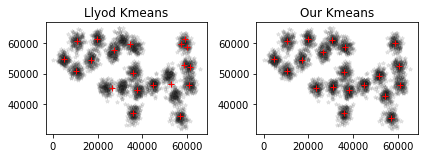

In [14]:
#--------------------------------------------------------------------------------
#------------------------------------Figure--------------------------------------
#--------------------------------------------------------------------------------
figure()
fig = plt.figure()
#Fisrt plot
plt.subplot(121)
ax = plt.subplot(221)
ax.set_title('Llyod Kmeans')
plot(dataMat[:, 0], dataMat[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plot(store_C[0][:, 0],store_C[0][:, 1], 'r+')
'''
i = 0
for a,b in zip(store_C[0][:, 0],store_C[0][:, 1]):
    i += 1
    plt.text(a+2, b+2, '%.0f'% i, color = "G", ha='center', va= 'bottom',fontsize=9)
'''
#Second plot
plt.subplot(122)
ax = plt.subplot(222)
ax.set_title('Our Kmeans')
plot(dataMat[:, 0], dataMat[:, 1], 'k*',markerfacecolor=(0.5, 0.5, 0.5, 0.1), markersize=4)
plot(store_C[-1][:, 0],store_C[-1][:, 1], 'r+')
'''
i = 0
for a,b in zip(store_C[-1][:, 0],store_C[-1][:, 1]):
    i += 1
    plt.text(a+2, b+2, '%.0f'% i, color = "G", ha='center', va= 'bottom',fontsize=9)
'''
#adjust entire empty space
fig.tight_layout()